In [119]:
import os
import time
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from google.cloud import storage
pio.renderers.default = 'notebook'

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [120]:
# Set path
relative_path = '../../deep-flash-sa.json'
file_path = os.path.abspath(relative_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = file_path
storage_client = storage.Client()

In [121]:
def read_data_from_gcs(bucket_name, folder, filename, delimiter=','):
    start_time = time.time()  # Start measuring time
    blob = storage_client.get_bucket(bucket_name).blob(f'{folder}/{filename}')
    csv_data = blob.download_as_text()
    df = pd.read_csv(StringIO(csv_data), delimiter=delimiter)
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Read {filename} complete. Elapsed time: {elapsed_time:.2f} seconds")
    return df

def remove_lawyers(df, lawyer_ids):
    filtered_df = df[~df['lawyer_id'].isin(lawyer_ids)]
    return filtered_df

In [122]:
df_consultations = read_data_from_gcs('perqara-dendrobium', 'raw/postgres/csv/consultations', 'consultations.csv', delimiter='|')

Read consultations.csv complete. Elapsed time: 3.43 seconds


In [123]:
#remove testing user
df_consultations = remove_lawyers(df_consultations, [36, 38, 48, 120, 192, 195])
df_consultations = df_consultations[df_consultations['status'] == 600]
df_consultations['created_at'] = pd.to_datetime(df_consultations['created_at'])

In [124]:
count = df_consultations['created_at'].to_frame().reset_index(drop=True)
# Set 'timestamp' as the DataFrame index
count.set_index('created_at', inplace=True)
# Resample the data to daily count and reset the index
df_daily_count = count.resample('D').size().reset_index()
# Rename the columns
df_daily_count.rename(columns={'created_at': 'date', 0: 'count'}, inplace=True)

In [125]:
df_daily_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    152 non-null    datetime64[ns]
 1   count   152 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 KB


# Time Series Analysis

In [134]:
df_cons = df_daily_count.copy()

In [160]:
#change to month
df_cons['month'] = df_cons['date'].dt.month
df_month_vis = df_cons.groupby('month')['count'].sum().reset_index()
df_month_vis = df_month_vis[:-1]
df_month_vis

,month,count
0,5,29
1,6,146
2,7,373
3,8,386
4,9,819


In [161]:
# Rename month numbers to month names
month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df_month_vis['month'] = df_month_vis['month'].map(month_mapping)

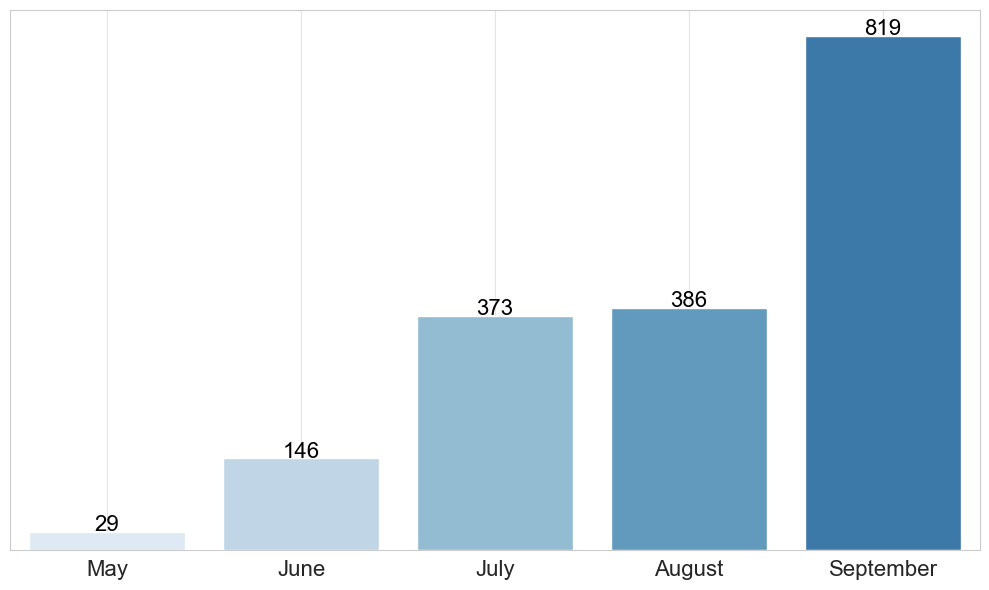

In [173]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("Blues")

# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.barplot(data=df_month_vis, x='month', y='count')

# Customize the plot
plt.title('')
plt.xlabel('')  # Set x-axis label to an empty string
plt.ylabel('')
plt.xticks(fontsize=16)  # Rotate x-axis labels for better readability

# Remove y-axis tick marks
ax.set_yticks([])

# Add numbers above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=16, color='black', xytext=(0, 5), textcoords='offset points')


# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

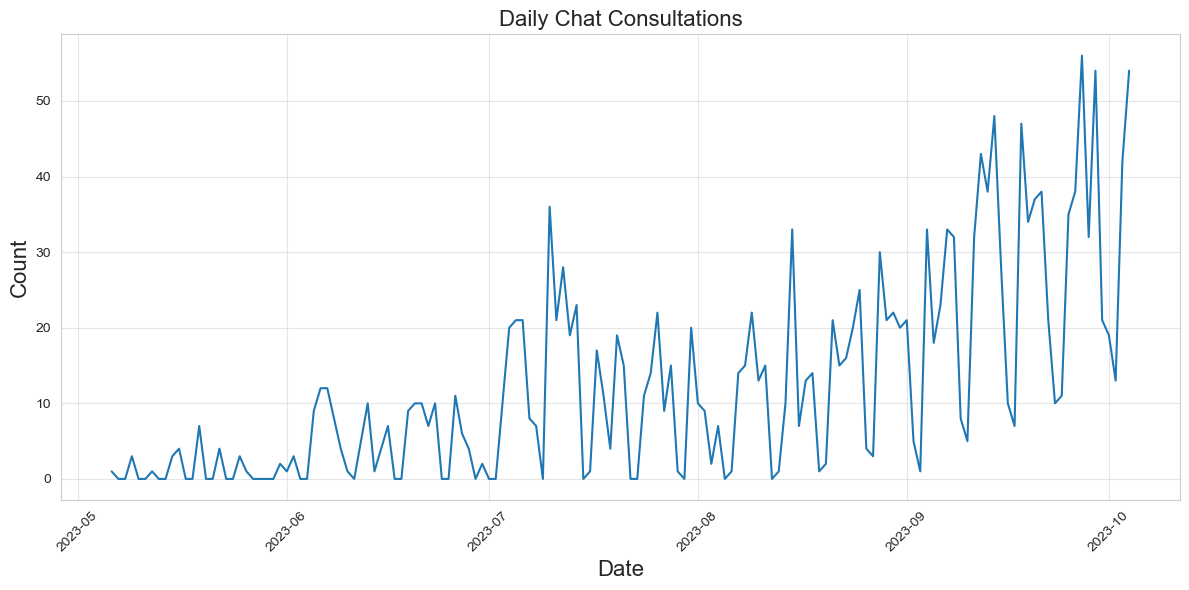

In [171]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(data=df_daily_count, x='date', y='count')

# Customize the plot
plt.title('Daily Chat Consultations', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

In [127]:
df_test = df_daily_count.copy()
df_test.set_index('date', inplace=True)
start_date = '2023-06-01'
end_date = '2023-10-02'
selected_data = df_test[start_date:end_date]

In [128]:
# Sample holiday dates
holidays = {'2023-06-29':'Idhul Adha',
            '2023-07-19':'Tahun Baru Islam',
            '2023-08-17':'HUT RI',
            '2023-09-28':'Maulid Nabi'}

In [129]:


# Convert holiday dates to datetime objects
holiday_dates = pd.to_datetime(list(holidays.keys()))

holiday_names = list(holidays.values())

In [130]:
selected_data

,count
date,
2023-06-01,1
2023-06-02,3
2023-06-03,0
2023-06-04,0
2023-06-05,9
...,...
2023-09-28,32
2023-09-29,54
2023-09-30,21


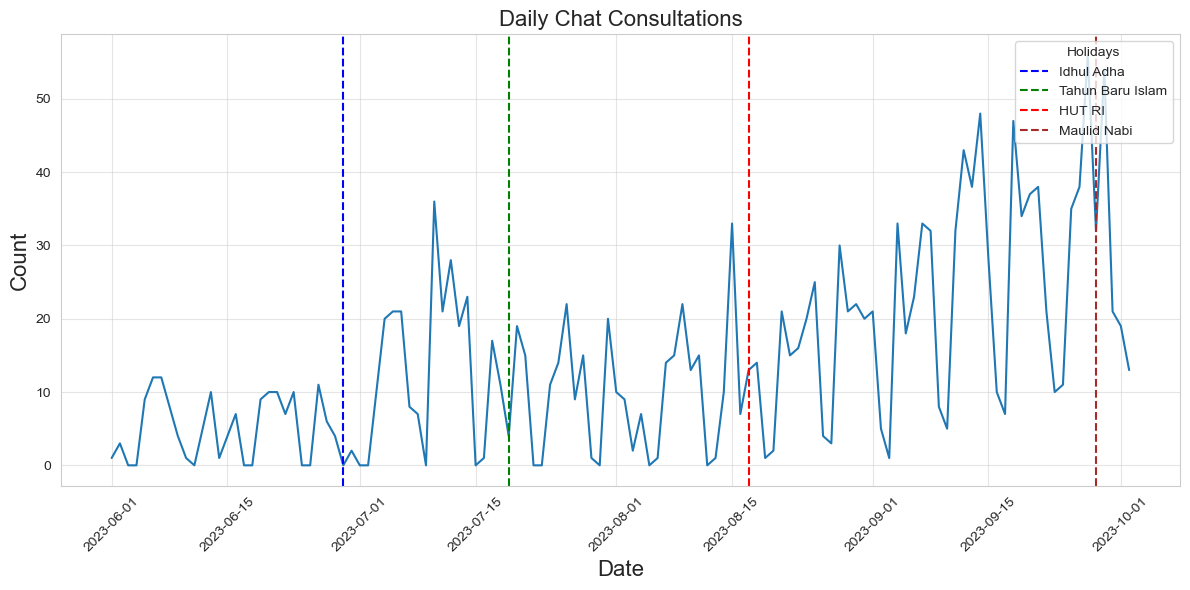

In [131]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(data=selected_data, x='date', y='count')

# Add marks for holidays with different colors
holiday_colors = ['blue','green', 'red', 'brown']  # Customize these colors as needed

for i, holiday in enumerate(holidays):
    plt.axvline(x=holiday, color=holiday_colors[i], linestyle='--')
    
# Add a custom legend for holiday information with different colors
holiday_labels = holiday_names  # Customize these labels as needed
holiday_legend = [plt.Line2D([0], [0], color=color, linestyle='--', label=label) for label, color in zip(holiday_labels, holiday_colors)]
plt.legend(handles=holiday_legend, title='Holidays', loc='upper right')

# Customize the plot
plt.xlabel('Date', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Daily Chat Consultations', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

In [132]:
# Calculate summary statistics
max_value = df_daily_count["count"].max()
min_value = df_daily_count["count"].min()

mean_value = df_daily_count["count"].mean()
median_value = df_daily_count["count"].median()
mode_value = df_daily_count["count"].mode()
std_value = df_daily_count["count"].std()
skewness = df_daily_count["count"].skew()

print(f"Min: {min_value}")
print(f"Max: {max_value}")
print('-----')
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")
print(f"Standard Deviation: {std_value}")
print(f"Skewness: {skewness}")
print('-----')
percentiles = df_daily_count['count'].quantile([0.25, 0.5, 0.75])
print(f"25th Percentile: {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile: {percentiles[0.75]}")

Min: 0
Max: 56
-----
Mean: 12.375
Median: 9.0
Mode: 0    0
Name: count, dtype: int64
Standard Deviation: 13.437031217758626
Skewness: 1.2458869593125554
-----
25th Percentile: 1.0
50th Percentile (Median): 9.0
75th Percentile: 20.0


In [28]:
# Identify outliers using IQR method
Q1 = percentiles[0.25]
Q3 = percentiles[0.75]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_daily_count[(df_daily_count['count'] < lower_bound) | (df_daily_count['count'] > upper_bound)]
print("Outliers:")
print(outliers)

Outliers:
          date  count
144 2023-09-27     56
146 2023-09-29     54
151 2023-10-04     54


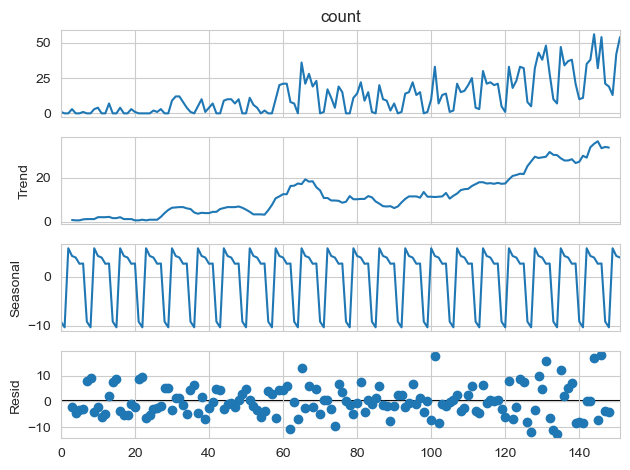

In [29]:
# Seasonal decomposition
your_seasonal_period = 7
result = seasonal_decompose(df_daily_count["count"], model="additive", period=your_seasonal_period)

# Plot decomposed components
result.plot()
plt.show()

In [30]:
trend = result.trend
seasonal = result.seasonal

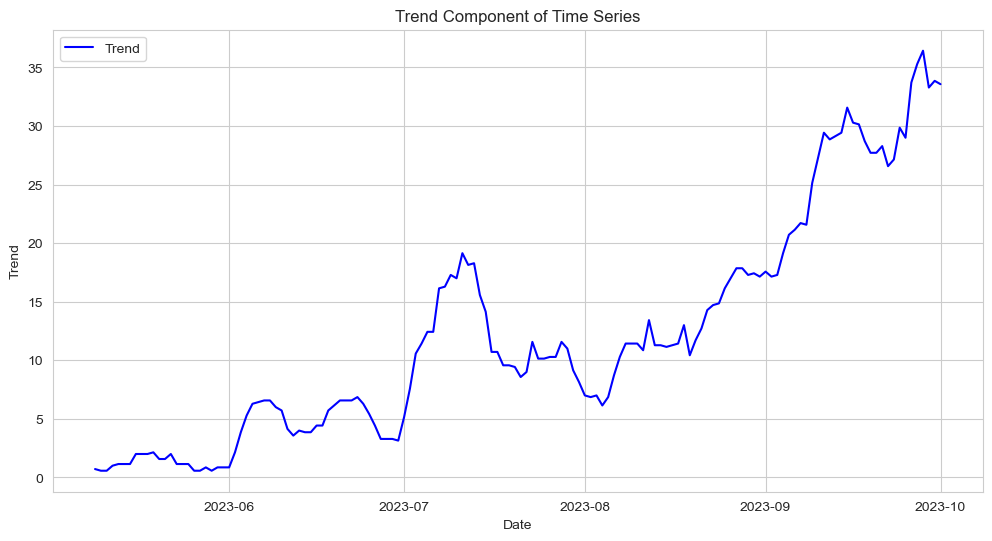

In [31]:
# Plot only the trend component
plt.figure(figsize=(12, 6))
plt.plot(df_daily_count['date'], trend, label='Trend', color='Blue')
plt.title('Trend Component of Time Series')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [32]:
df_seasonal = df_daily_count.copy()
df_seasonal.set_index('date', inplace=True)

day_names = df_seasonal.index.strftime('%A')
day_names

Index(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Monday',
       ...
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype='object', name='date', length=152)

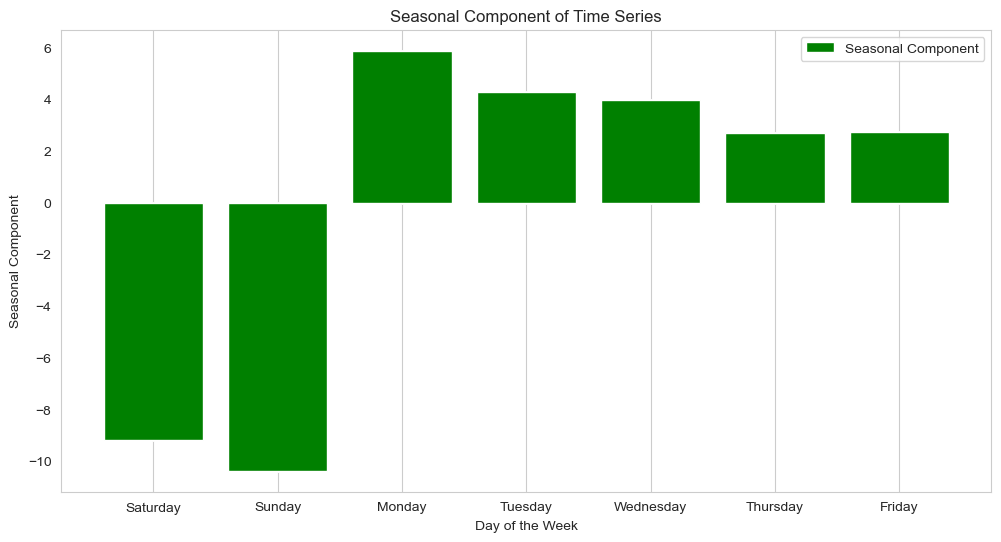

In [33]:
# Create a bar plot with custom x-axis labels
plt.figure(figsize=(12, 6))
plt.bar(day_names, seasonal, color='green', label='Seasonal Component')

# Customize the plot
plt.title('Seasonal Component of Time Series')
plt.xlabel('Day of the Week')
plt.ylabel('Seasonal Component')
plt.legend(loc='best')
plt.grid(axis='y')  # Grid lines only on the y-axis
plt.show()

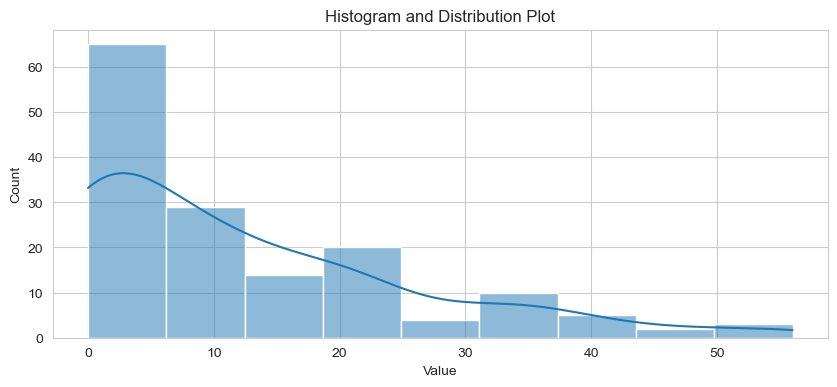

In [34]:
# Histogram and distribution plot
plt.figure(figsize=(10, 4))
sns.histplot(df_daily_count["count"], kde=True)
plt.title("Histogram and Distribution Plot")
plt.xlabel("Value")
plt.show()

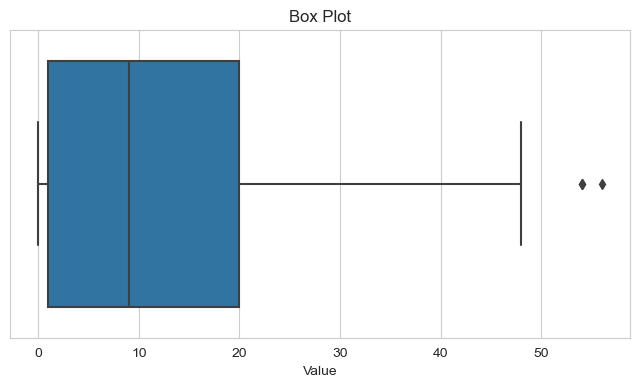

In [35]:
# Box plot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_daily_count["count"])
plt.title("Box Plot")
plt.xlabel("Value")
plt.show()

In [36]:
# trend analysis
# Calculate a simple moving average (SMA) to smooth out noise and visualize trends
window_size = 7  # You can adjust this window size as needed
sma = df_daily_count['count'].rolling(window=window_size).mean()

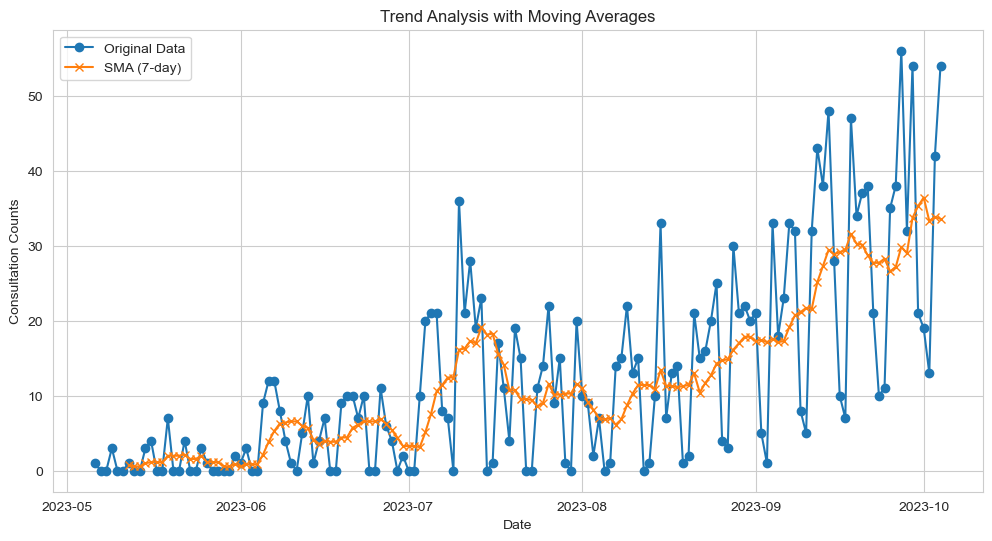

In [37]:
# Plot the original data and the smoothed data (SMA)
plt.figure(figsize=(12, 6))
plt.plot(df_daily_count['date'], df_daily_count['count'], label='Original Data', linestyle='-', marker='o')
plt.plot(df_daily_count['date'], sma, label=f'SMA ({window_size}-day)', linestyle='-', marker='x')
plt.xlabel('Date')
plt.ylabel('Consultation Counts')
plt.title('Trend Analysis with Moving Averages')
plt.legend()
plt.grid(True)

plt.show()

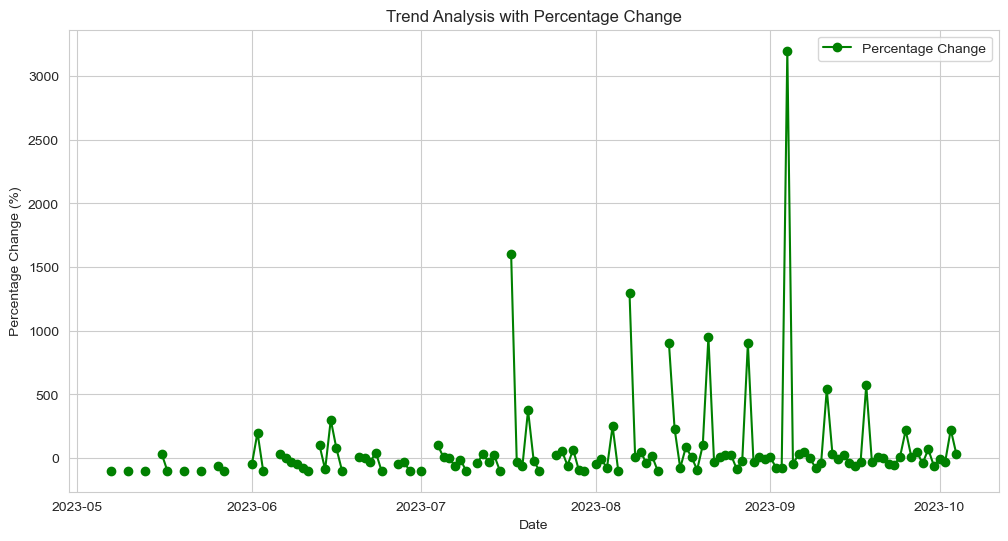

In [38]:
# Calculate percentage change over time
df_daily_count_change = df_daily_count.copy()
df_daily_count_change['PercentageChange'] = df_daily_count_change['count'].pct_change() * 100

# Plot the percentage change
plt.figure(figsize=(12, 6))
plt.plot(df_daily_count_change['date'], df_daily_count_change['PercentageChange'], label='Percentage Change', linestyle='-', marker='o', color='green')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.title('Trend Analysis with Percentage Change')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
adf_results = adfuller(df_daily_count['count'])
print(f'ADF statistics: {adf_results[0]}')
print(f'p-value: {adf_results[1]}')

ADF statistics: 0.8343686713505287
p-value: 0.9921711673859523


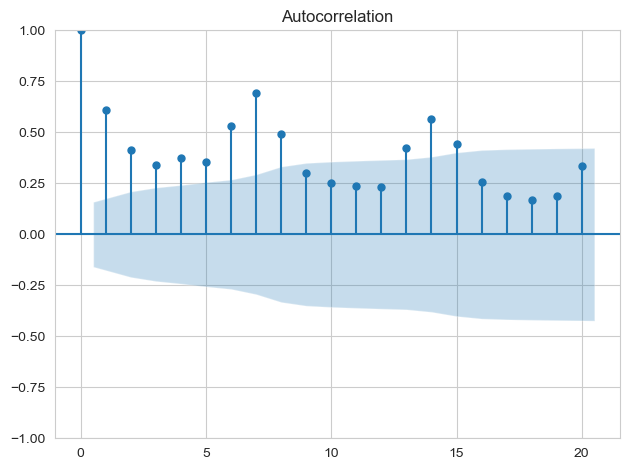

In [40]:
plot_acf(df_daily_count['count'], lags=20)
plt.tight_layout()

In [41]:
# 4. Apply first-order different
diff_random_walk = np.diff(df_daily_count['count'], n=1)
# 5. Test for stationray
adf_results = adfuller(diff_random_walk)
print(f'ADF statistics: {adf_results[0]}')
print(f'p-value: {adf_results[1]}')

ADF statistics: -5.985901215434196
p-value: 1.7925491546597316e-07


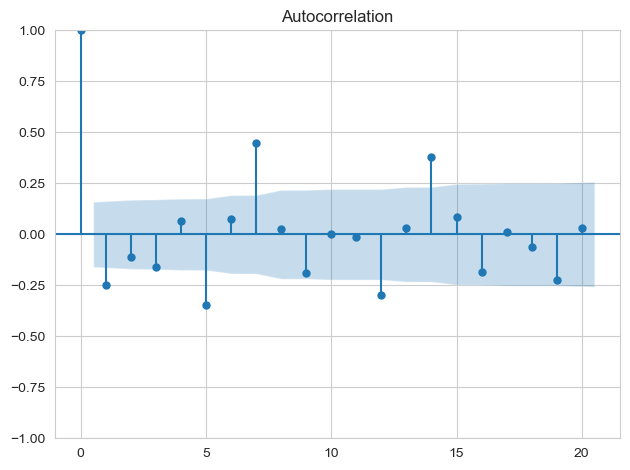

In [42]:
plot_acf(diff_random_walk, lags=20)
plt.tight_layout()

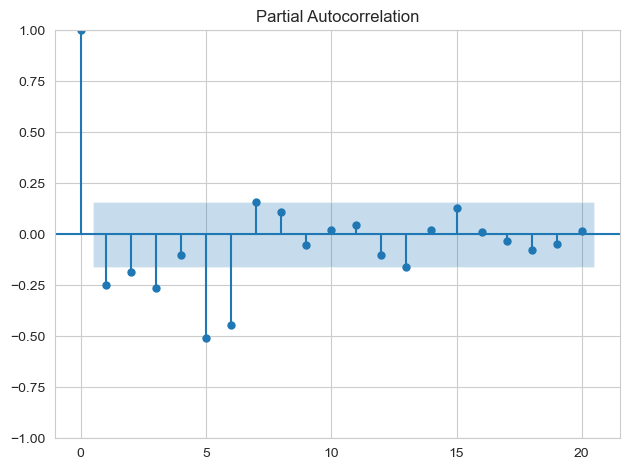

In [43]:
plot_pacf(diff_random_walk, lags=20);

plt.tight_layout()